In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from childes_mi.utils.paths import CHILDES_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
transcript_df = pd.read_pickle(CHILDES_DFS/'childes_df.pickle')
#transcript_df['dataset'] = [i[0].split('/')[11] for i in transcript_df.transcript_xml.values]
len(transcript_df)

123175

In [6]:
# mask for only a subset of corpuses
possible_corpuses = [
    # carterette is also transcribed in IPA
    "Carterette",  # 1st, 3rd, 5th grade, adults, speech naturalistic speech in IPA https://childes.talkbank.org/access/Eng-NA/Carterette.html
    "Gillam",  # normal subset, spontaneous storytelling 5-11y11m https://childes.talkbank.org/access/Clinical-MOR/Gillam.html
    "Braunwald",  # single subject from 1-6yo talking to family https://childes.talkbank.org/access/Eng-NA/Braunwald.html
    "Brown",  # 1y6m-5y1m, 3 subjects naturalistic talking to parents https://childes.talkbank.org/access/Eng-NA/Brown.html
    "EllisWeismer",  # 2y6m - 5y6 naturalistic play-oriented talk with instructor # https://childes.talkbank.org/access/Clinical-MOR/EllisWeismer.html
    "Gleason",  # 2;1 - 5;2 family interactions https://childes.talkbank.org/access/Eng-NA/Gleason.html
    "NH",# Nicholas-NH,  # 1;0-4;0, videotaped play with parent https://childes.talkbank.org/access/Clinical-MOR/Nicholas/NH.html
    "Post",  # 1;7-2;8 60m session with family and toys https://childes.talkbank.org/access/Eng-NA/Post.html
    "Normal",  #  Rondal-Normal 3-12yo free play with mother and child https://childes.talkbank.org/access/Clinical-MOR/Normal /Normal.html
]
corpus_mask = [corpus in possible_corpuses for corpus in transcript_df.corpus.values]
transcript_df = transcript_df[corpus_mask]

In [7]:
# mask for a subset of roles
possible_roles = ['Target_Child', 'Child']
role_mask = [role in possible_roles for role in transcript_df.role.values]
transcript_df = transcript_df[role_mask]
len(transcript_df)

2785

In [8]:
transcript_df[:3]

,PID,lang,corpus,date,participant_key,role,age,language,sex,POS,words,morphemes,transcript_xml,n_words,n_morphemes,n_POS
72301,11312/c-00015848-1,eng,Carterette,1984-01-01,CHI,Target_Child,P6Y,eng,NaN,"[[pro:per, v, , , conj, n:prop, coord, pro:ind...","[[you, mean, uh, um, like, England, or, someth...","[[you, mean, uh, um, like, England, or, someth...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,2102,2102,2102
72302,11312/c-00015847-1,eng,Carterette,1984-01-01,CHI,Target_Child,P10Y,eng,NaN,"[[co, , pro:sub, v, , det:num, n], [coord, , p...","[[well, um, I, have, uh, one, sister], [and, u...","[[well, um, I, have, uh, one, sister], [and, u...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,2729,2729,2729
72303,11312/c-00015849-1,eng,Carterette,1984-01-01,CHI,Target_Child,P8Y,eng,NaN,"[[v, n, n], [co, n:prop, v, prep, det:art, n, ...","[[lets, watch, tv], [well, Nancy, said, for, t...","[[let-3S, watch, tv], [well, Nancy, say-PAST, ...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,2019,2019,2019


In [9]:
transcript_df.iloc[0]

PID                                               11312/c-00015848-1
lang                                                             eng
corpus                                                    Carterette
date                                                      1984-01-01
participant_key                                                  CHI
role                                                    Target_Child
age                                                              P6Y
language                                                         eng
sex                                                              NaN
POS                [[pro:per, v, , , conj, n:prop, coord, pro:ind...
words              [[you, mean, uh, um, like, England, or, someth...
morphemes          [[you, mean, uh, um, like, England, or, someth...
transcript_xml     [/mnt/cube/tsainbur/Projects/github_repos/chil...
n_words                                                         2102
n_morphemes                       

In [10]:
transcript_df['n_words'] = [len(np.concatenate(i)) if len(i) > 0 else 0 for i in transcript_df.words.values]

In [11]:
print(transcript_df.corpus.unique())

['Carterette' 'Brown' 'Braunwald' 'Post' 'Gleason' 'Normal' 'Gillam'
 'EllisWeismer' 'NH']


In [12]:
print("there are {} words in this dataset".format(np.sum(transcript_df.n_words.values)))

there are 1247296 words in this dataset


### Get child ages

In [13]:
import re
def convert_age(age_year):
    "Caclculate age in months from a string in CHILDES format"
    if age_year[-1] == 'Y':
        age_year += '0'
    m = re.match("P(\d+)Y(\d+)M?(\d?\d?)D?", age_year)
    age_month = int(m.group(1)) * 12 + int(m.group(2))
    try:
        if int(m.group(3)) > 15:
            age_month += 1
    # some corpora don't have age information?
    except ValueError as e:
        pass
    return age_month

In [14]:
transcript_df["age_months"] = [
    convert_age(i) if type(i) == str else np.nan for i in tqdm(transcript_df.age.values)
]

In [15]:
transcript_df["age_years"] = transcript_df["age_months"] / 12

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


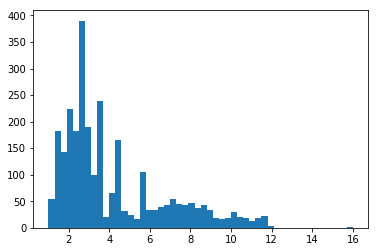

In [16]:
plt.hist(transcript_df.age_years.values, bins = 50);

In [17]:
transcript_df[:3]

,PID,lang,corpus,date,participant_key,role,age,language,sex,POS,words,morphemes,transcript_xml,n_words,n_morphemes,n_POS,age_months,age_years
72301,11312/c-00015848-1,eng,Carterette,1984-01-01,CHI,Target_Child,P6Y,eng,NaN,"[[pro:per, v, , , conj, n:prop, coord, pro:ind...","[[you, mean, uh, um, like, England, or, someth...","[[you, mean, uh, um, like, England, or, someth...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,19903,2102,2102,72.0,6.0
72302,11312/c-00015847-1,eng,Carterette,1984-01-01,CHI,Target_Child,P10Y,eng,NaN,"[[co, , pro:sub, v, , det:num, n], [coord, , p...","[[well, um, I, have, uh, one, sister], [and, u...","[[well, um, I, have, uh, one, sister], [and, u...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,26941,2729,2729,120.0,10.0
72303,11312/c-00015849-1,eng,Carterette,1984-01-01,CHI,Target_Child,P8Y,eng,NaN,"[[v, n, n], [co, n:prop, v, prep, det:art, n, ...","[[lets, watch, tv], [well, Nancy, said, for, t...","[[let-3S, watch, tv], [well, Nancy, say-PAST, ...",[/mnt/cube/tsainbur/Projects/github_repos/chil...,21419,2019,2019,96.0,8.0


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0.8, 6)

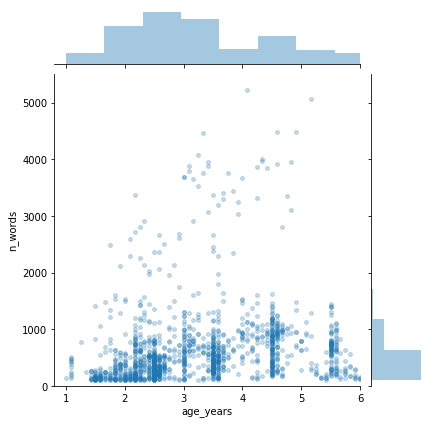

In [18]:
import seaborn as sns

grd = sns.jointplot(
    "age_years",
    "n_words",
    data=transcript_df[transcript_df.n_words > 100],
    alpha=0.25,
    s=15,
)
ax = grd.ax_joint
ax.set_ylim([0, 5500])
ax.set_xlim([0.8, 6])

In [19]:
import seaborn as sns
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig
ensure_dir(FIGURE_DIR/ 'distributions')

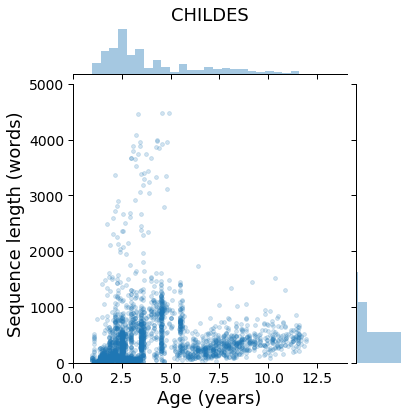

In [20]:
sns.set_context("paper", rc={"font.size":24,"axes.titlesize":18,"axes.labelsize":18, "axes.ticksize":14})   

p = sns.jointplot("age_years", "n_words", data=transcript_df, alpha=0.2, annot_kws={"size": 16}, s=15)

p.set_axis_labels(xlabel="Age (years)", ylabel="Sequence length (words)")
p.ax_joint.tick_params(labelsize=14)
p.ax_marg_x.set_title("CHILDES")
p.ax_joint.set_ylim([0,5000])
p.ax_joint.set_xlim([0,14])
save_fig(FIGURE_DIR/ 'distributions' / 'childes_distribution')
plt.show()

In [ ]:
np.mean(transcript_df.n_words)

447.862118491921

### Sentence lengths

In [ ]:
# sentence_df = pd.DataFrame(columns = ['age_years', 'sentence_length'])
sentence_df = pd.DataFrame(
    [
        [row.age_years, len(i)]
        for idx, row in tqdm(transcript_df.iterrows(), total=len(transcript_df))
        for i in row.words
    ],
    columns=["age_years", "sentence_length"],
)

In [ ]:
len(sentence_df)

341548

In [ ]:
sentence_df[:3]

,age_years,sentence_length
0,6.0,8
1,6.0,12
2,6.0,9


(0.8, 6)

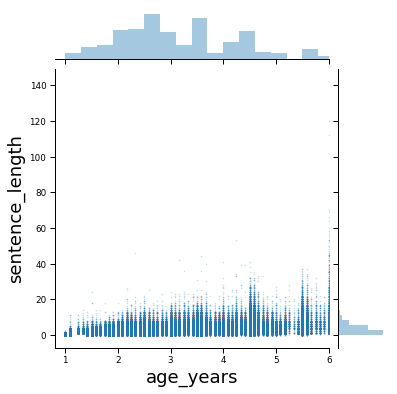

In [ ]:
import seaborn as sns

grd = sns.jointplot(
    "age_years",
    "sentence_length",
    data=sentence_df,
    alpha=0.15,
    s=1,
    #kind="hex"
)
ax = grd.ax_joint
#ax.set_ylim([0, 1500])
ax.set_xlim([0.8, 6])

### dataset statistics

In [ ]:
age_cohorts = [[1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [ ]:

for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    
    cohort_subset = transcript_df[
        (transcript_df.age_months/12 > age_cohort_low) & (transcript_df.age_months/12 <= age_cohort_high)
    ]
    
    cohort_words = [[i for i in list(flatten(row.words)) if i not in [None, 'xxx']] for idx, row in cohort_subset.iterrows()]
    
    n_words = len(np.concatenate(cohort_words))
    n_unique_words = len(np.unique(np.concatenate(cohort_words)))
    
    print(age_cohort_low, age_cohort_high, np.median([len(i) for i in cohort_words]), n_words, n_unique_words)
    #plt.hist([len(i) for i in cohort_words])
    #plt.show()

1 1.5 38.0 15154 1239
1.5 2 98.0 57580 3199
2 2.5 204.0 167722 5363
2.5 3 121.5 110580 4995
3 20 394.0 855307 14410



## MI
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

In [ ]:
from childes_mi.information_theory import mutual_information as mi

#### Run MI by age cohort

In [ ]:
distances = np.arange(1,101)

In [ ]:
def remove_repeats(sequence):
    if len(sequence) == 0:
        return sequence
    a = np.array(sequence[1:])
    b = np.array(sequence[:-1])
    c = [sequence[0]] + list(a[a != b])
    return c

In [ ]:
mi_df = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_words",
        "n_unique_words",
        "top_10_words",
        "shuffling"
    ]
)
# for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    
    if age_cohort_low != 3: 
        continue
        
    print (age_cohort_low)
    cohort_subset = transcript_df[
        (transcript_df.age_months / 12 > age_cohort_low)
        & (transcript_df.age_months / 12 <= age_cohort_high)
    ]

    # cohort_words = [[row.PID + "_" + i for i in list(flatten(row.words)) if i not in [None, 'xxx']] for idx, row in cohort_subset.iterrows()]
    cohort_words = [
        [i for i in list(flatten(row.words)) if i not in [None, "xxx"]]
        for idx, row in cohort_subset.iterrows()
    ]
    cwl = np.array([len(i) for i in cohort_words])
    #cohort_words = [i[:500] for i in cohort_words if len(i) > 500]
    #cohort_words = np.array(cohort_words)[np.argsort(cwl)[-10:]]
    
    print(cohort_words[0][:5])

    n_words = len(np.concatenate(cohort_words))
    n_unique_words = len(np.unique(np.concatenate(cohort_words)))

    # cohort_word_list = np.concatenate([np.concatenate(i) for i in cohort_subset.words.values])
    # most_frequent_words = pd.DataFrame({i:[sum(cohort_word_list == i)] for i in tqdm(np.unique(cohort_word_list))})
    # top_10_words = most_frequent_words.T.sort_values(by=0, ascending=False)[:10].T.columns

    n_unique_words = 0
    top_10_words = 0
    
    
    median_n_words = int(np.median([len(i) for i in cohort_words]))
    #distances = np.arange(1, np.max([100, median_n_words]) + 1, 5)
    distances = np.arange(1, 250 + 1, 5)
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_words, distances=distances, n_jobs=1, estimate=False
    )
    plt.loglog(distances, MI - shuff_MI)
    plt.show()

    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_words,
        n_unique_words,
        top_10_words,
        "full"
    ]
    
  

3
['you', 'mean', 'uh', 'um', 'like']


In [ ]:
plt.plot(distances, MI)
plt.plot(distances, MI_var)
plt.plot(distances, shuff_MI)

In [ ]:
plt.loglog(distances, MI - shuff_MI, alpha = 0)
plt.scatter(distances, MI - shuff_MI)

In [97]:
mi_df[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_words,n_unique_words,top_10_words,shuffling
0,"[-162981.45029891375, -256431.45055189403, -26...","[615.6355080992051, 602.7012029122511, 599.276...","[-274052.450568694, -272912.4505457965, -27082...","[602.6594936990116, 599.9998432839612, 597.433...","[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56,...",3,20,855307,0,0,full


In [ ]:
#mi_df.to_pickle(DATA_DIR / "mi" / "childes_mi_with_shuffling.pickle")

full


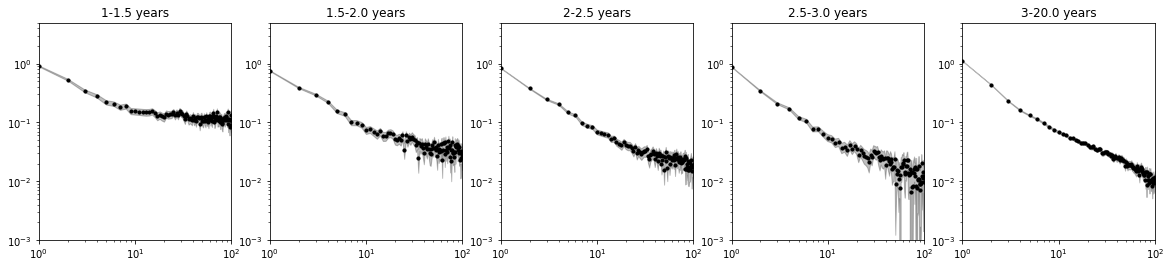

shuffle_within_sentences


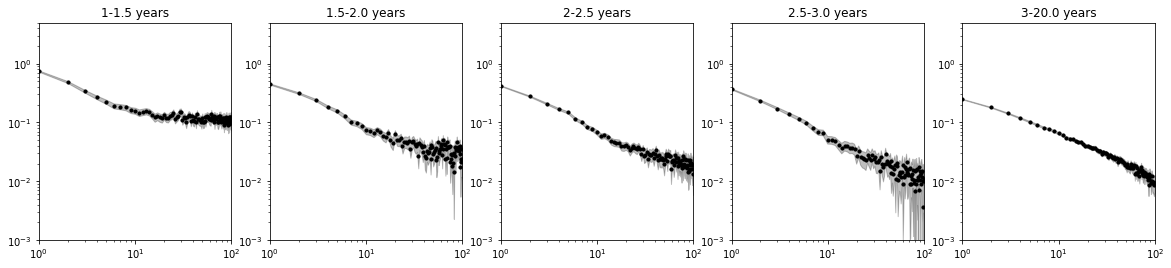

shuffle_between_sentences


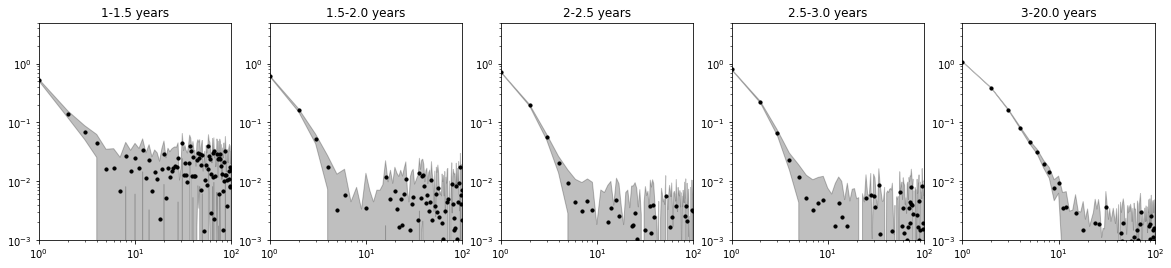

no_repeats


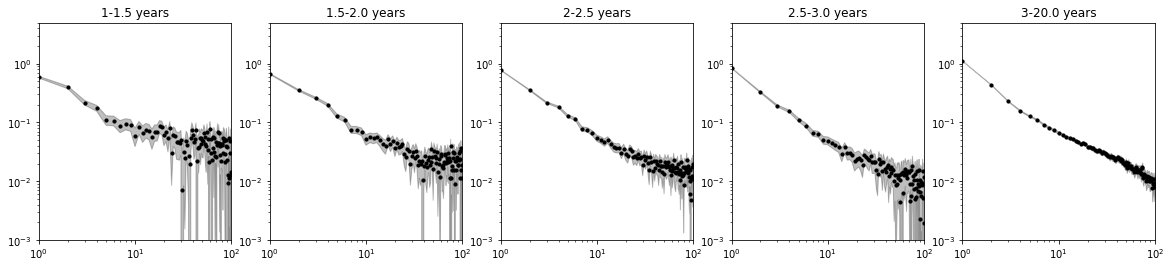

In [29]:
fig, ax = plt.subplots()
row = mi_df.iloc[0]
MI = row.MI-row.shuff_MI
MI_var = row.MI_var
#ax.scatter(distances, row.MI-row.shuff_MI)
#ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
ax.scatter(distances, row.MI-row.shuff_MI, s=10, color='k')
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
#ax.legend()
ax.set_title('{}-{} years'.format(row.age_cohort_low, row.age_cohort_high))
ax.set_ylim([1e-3,5])
ax.set_xlim([1, 100])

ax.set_yscale('log')
ax.set_xscale('log')
plt.show()